In [41]:

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
df = pd.read_json(open("./dataset/train.json", "r"))

In [68]:
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day

features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day"]

In [69]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
lbl.fit(list(df['manager_id'].values))
df['manager_id'] = lbl.transform(list(df['manager_id'].values))

# let's add this feature
features_to_use.append('manager_id')


In [70]:
# Let's split the data
X = df[features_to_use]
y = df["interest_level"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)



In [71]:
# compute fractions and count for each manager




temp = pd.concat([X_train.manager_id,pd.get_dummies(y_train)], axis = 1).groupby('manager_id').mean()

temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = X_train.groupby('manager_id').count().iloc[:,1]

# remember the manager_ids look different because we encoded them in the previous step 
print(temp.tail(10))

            high_frac  low_frac  medium_frac  count
manager_id                                         
3470         0.000000  0.000000     1.000000      1
3471         0.000000  0.666667     0.333333      3
3472         0.714286  0.142857     0.142857      7
3473         0.000000  1.000000     0.000000      1
3475         0.200000  0.600000     0.200000      5
3476         0.000000  1.000000     0.000000      1
3477         0.000000  1.000000     0.000000      4
3478         0.000000  1.000000     0.000000      1
3479         0.250000  0.500000     0.250000      4
3480         0.027027  0.689189     0.283784     74


In [72]:
# compute skill
temp['manager_skill'] = temp['high_frac']*2 +  temp['medium_frac'] 
# get ixes for unranked managers...
unranked_managers_ixes = temp['count']<20
# ... and ranked ones
ranked_managers_ixes = ~unranked_managers_ixes

# compute mean values from ranked managers and assign them to unranked ones
mean_values = temp.loc[ranked_managers_ixes, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
print(mean_values)
temp.loc[unranked_managers_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
print(temp.tail(10))

high_frac        0.078404
low_frac         0.665484
medium_frac      0.256113
manager_skill    0.412920
dtype: float64
            high_frac  low_frac  medium_frac  count  manager_skill
manager_id                                                        
3470         0.078404  0.665484     0.256113      1       0.412920
3471         0.078404  0.665484     0.256113      3       0.412920
3472         0.078404  0.665484     0.256113      7       0.412920
3473         0.078404  0.665484     0.256113      1       0.412920
3475         0.078404  0.665484     0.256113      5       0.412920
3476         0.078404  0.665484     0.256113      1       0.412920
3477         0.078404  0.665484     0.256113      4       0.412920
3478         0.078404  0.665484     0.256113      1       0.412920
3479         0.078404  0.665484     0.256113      4       0.412920
3480         0.027027  0.689189     0.283784     74       0.337838


In [73]:
# inner join to assign manager features to the managers in the training dataframe
X_train = X_train.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
X_train.head()

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day,manager_id,high_frac,low_frac,medium_frac,count,manager_skill
0,1.0,2,40.7672,-73.9867,3450,6,4,171,2016,5,26,45,0.037736,0.509434,0.452830,53,0.528302
1,1.0,0,40.7801,-73.9544,1900,2,2,38,2016,6,26,319,0.078404,0.665484,0.256113,9,0.412920
2,2.0,4,40.7413,-73.9781,5995,5,9,109,2016,4,27,795,0.258065,0.225806,0.516129,31,1.032258
3,1.5,3,40.7304,-74.0050,5295,10,8,191,2016,4,6,2930,0.078404,0.665484,0.256113,12,0.412920
4,1.0,2,40.7436,-73.9727,3500,11,13,133,2016,4,6,1303,0.068966,0.689655,0.241379,29,0.379310


In [74]:
# add the features computed on the training dataset to the validation dataset
X_val = X_val.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = X_val['high_frac'].isnull()
X_val.loc[new_manager_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values
X_val.head()



,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_description_words,created_year,created_month,created_day,manager_id,high_frac,low_frac,medium_frac,count,manager_skill
0,1.0,2,40.7565,-73.9973,3700,8,14,120,2016,5,10,3341,0.121212,0.242424,0.636364,33.0,0.878788
1,1.0,2,40.7073,-74.0046,2500,4,8,70,2016,6,1,912,0.078404,0.665484,0.256113,18.0,0.412920
2,1.0,2,40.7198,-73.9891,3795,5,6,113,2016,5,11,2150,0.000000,0.923077,0.076923,26.0,0.076923
3,1.0,2,40.7207,-73.9801,4492,6,12,142,2016,4,26,839,0.078404,0.665484,0.256113,7.0,0.412920
4,1.0,0,40.7770,-73.9460,1710,4,2,29,2016,6,21,2839,0.260000,0.300000,0.440000,50.0,0.960000


In [75]:
features_to_use.extend(['high_frac','low_frac', 'medium_frac','manager_skill'])

In [29]:
# features to use for this classifier == only basic numerical
#0.62068654093626219
these_features = [f for f in features_to_use if f not in ['manager_id','high_frac','low_frac', 'medium_frac','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.62068654093626219

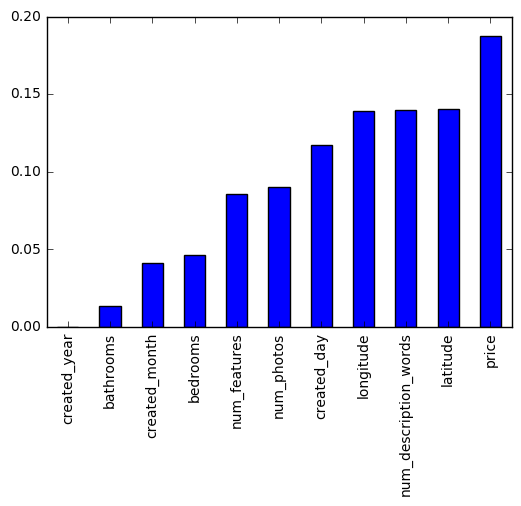

In [30]:
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')

In [31]:
these_features = [f for f in features_to_use if f not in ['high_frac','low_frac', 'medium_frac','manager_skill']]

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.6156322009637929

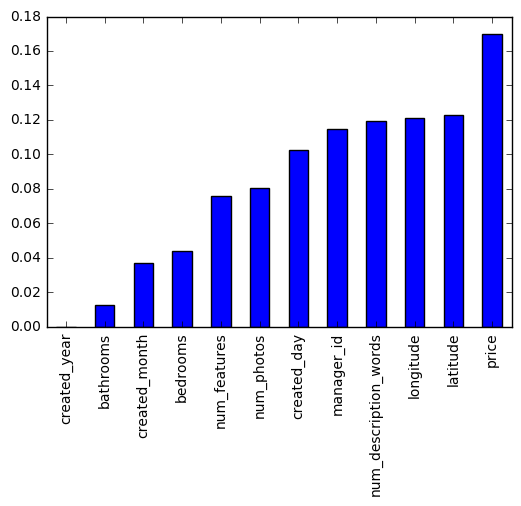

In [32]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')

In [82]:
# no manager_id, no fraction, use skill instead
#0.59939387962424462
these_features = [f for f in features_to_use if f not in ['manager_id','low_frac', 'medium_frac', 'high_frac']]

clf = RandomForestClassifier(n_estimators=2000)
clf.fit(X_train[these_features], y_train)
y_val_pred = clf.predict_proba(X_val[these_features])
log_loss(y_val, y_val_pred)

0.61242657851289206

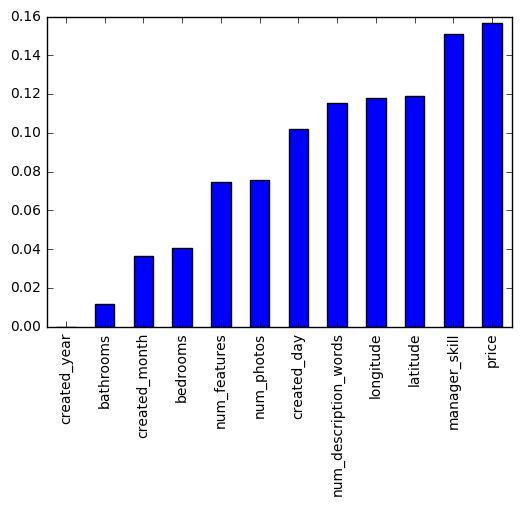

In [83]:
# Let's visualize features importance
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')